# Mixing functions

In [1]:
using Clapeyron, PyCall
import PyPlot; const plt = PyPlot

PyPlot

In this notebook, we give examples of how one can obtain bulk properties in `Clapeyron.jl`.

## Properties of water

First generating the model:

In [2]:
model = PCSAFT(["water"])

PCSAFT{BasicIdeal, Float64} with 1 component:
 "water"
Contains parameters: Mw, segment, sigma, epsilon, epsilon_assoc, bondvol

Bulk properties can be obtained as a function of temperature and pressure (`property(model, p, T)`) as shown below:

In [14]:
p = 1e5
T = LinRange(280.,600.,100)
V = volume.(model,p,T);

In the above, Clapeyron will solve for both the vapour and liquid roots and determine which is more stable. However, one can specify the phase of interest using the `phase` optional argument:

In [15]:
Vv = volume.(model,p,T;phase=:vapour)
Vl = volume.(model,p,T;phase=:liquid);

Plotting:

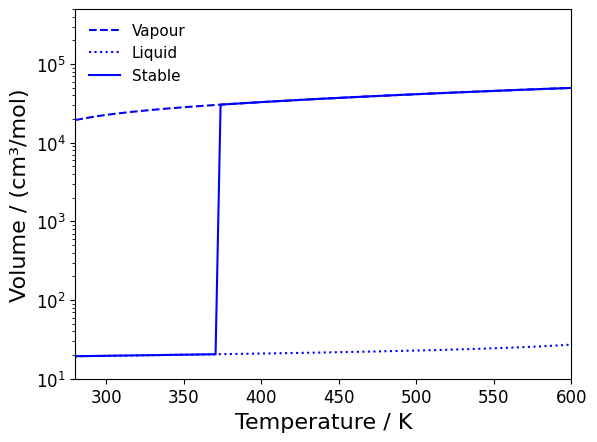

In [21]:
plt.clf()
plt.semilogy(T,Vv.*1e6,linestyle="--",color="blue",label="Vapour")
plt.semilogy(T,Vl.*1e6,linestyle=":",color="blue",label="Liquid")
plt.semilogy(T,V.*1e6,linestyle="-",color="blue",label="Stable")

plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Volume / (cm³/mol)",fontsize=16)
plt.ylim(1e1,5e5)
plt.xlim([280,600])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left",frameon=false,fontsize=11)
plt.savefig("volume_water.svg")
display(plt.gcf())

Another property of interest might be the isobaric heat capacity:

In [22]:
Cp = isobaric_heat_capacity.(model,p,T);

However, one will find that these predictions have been underestimated. This is because, by default, Clapeyron assumes that molecules only experience translational modes of motion. The additional contributions from rotations and vibrations can be obtained from ideal correlations such as the `ReidIdeal` model:

In [24]:
model_reid = PCSAFT(["water"];idealmodel=ReidIdeal)
Cp_reid = isobaric_heat_capacity.(model_reid,p,T);

We can see the impact of this below:

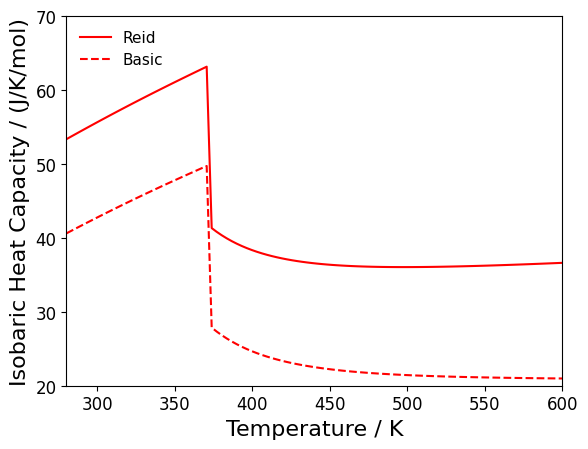

In [29]:
plt.clf()
plt.plot(T,Cp_reid,linestyle="-",color="red",label="Reid")

plt.plot(T,Cp,linestyle="--",color="red",label="Basic")

plt.xlabel("Temperature / K",fontsize=16)
plt.ylabel("Isobaric Heat Capacity / (J/K/mol)",fontsize=16)
plt.ylim(20,70)
plt.xlim(280,600)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left",frameon=false,fontsize=11)
plt.savefig("cp_water.svg")
display(plt.gcf())

## Volume of water + carbon dioxide

Let us now consider how to obtain bulk properties for mixtures. Initially, we construct a model:

In [58]:
model = PCSAFT(["water","carbon dioxide"]);

We can obtain the volume of this mixture by now specifying the molar amount (`property(model,p,T,z)`):

In [59]:
p = 1e5
T = 298.15
x = range(0,1,length=100)
X = Clapeyron.FractionVector.(x) # We used FractionVector to broadcast the composition

V = volume.(model,p,T,X);

However, one limitation of the above is that Clapeyron does not check for the stability of a system at a given set of conditions by default. For most of the compositions explored above, water and carbon dioxide will phase split. A more appropriate approach would be to use a flash algorithm:

In [61]:
(n,ϕ,G) = tp_flash(model,p,T,[0.5,0.5],RRTPFlash(equilibrium=:vle))
v1 = volume(model,p,T,n[1,:])
v2 = volume(model,p,T,n[2,:])
Vtrue = v1*x+v2*(1 .-x);

Plotting both results, we see very different results:

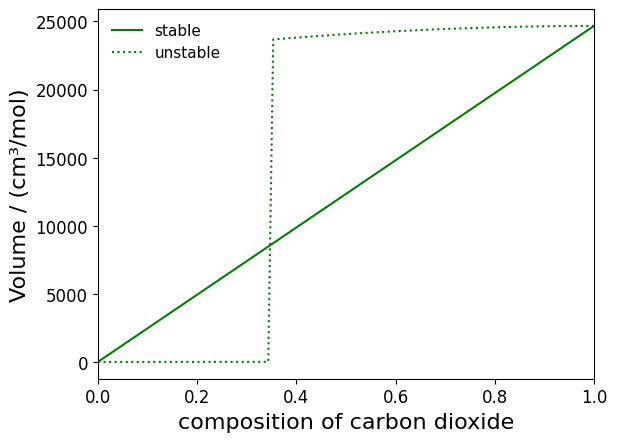

In [62]:
plt.clf()
plt.plot(1 .-x,Vtrue.*1e6,label="stable",linestyle="-",color="green")
plt.plot(1 .-x,V.*1e6,label="unstable",linestyle=":",color="green")


plt.xlabel("composition of carbon dioxide",fontsize=16)
plt.ylabel("Volume / (cm³/mol)",fontsize=16)
# plt.ylim([-3.5,4])
plt.xlim([0,1])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(frameon=false,fontsize=11) 
display(plt.gcf())